## Setup

In [4]:
# Get raw advent-of-code data
from aocd.models import Puzzle

puzzle = Puzzle(year=2025, day=3)
input_data = puzzle.input_data
examples = puzzle.examples

In [5]:
# Imports
from timeit import timeit

In [6]:
# Parse input data
def parse_banks(input_data: str) -> list[list[int]]:
    """Parse input text from string to list of banks (lists of integers)."""
    return [list(map(int, list(line))) for line in input_data.splitlines()]


input_banks = parse_banks(input_data)
example_banks = parse_banks(examples[0].input_data)

## Part a

### Iterative approach

I started with an iterative approach to find the largest digit to the right of each digit in the bank, and then selecting the highest combination as the max joltage for a bank.

In [ ]:
def calc_max_joltage_a_iterative(banks: list[list[int]]) -> int:
    """Calculate the total maximum joltage for a list of battery banks in an iterative way."""
    total_joltage = 0

    for bank in banks:
        max_joltage_bank = 0

        # Check each battery except the last one (because that one doesn't have any batteries after it)
        for i, battery in enumerate(bank[:-1]):
            # Find the maximum joltage after this battery combined with current battery joltage
            max_joltage_battery_combo = 10 * battery + max(bank[i + 1 :])

            # Update max joltage for this bank
            max_joltage_bank = max(max_joltage_bank, max_joltage_battery_combo)

        # Update total joltage with max joltage for this bank
        total_joltage += max_joltage_bank

    return total_joltage


In [ ]:
# Correctness check
str(calc_max_joltage_a_iterative(example_banks)) == examples[0].answer_a

True

In [44]:
# Performance check
iterative_time_a = timeit(lambda: calc_max_joltage_a_iterative(input_banks), number=50) / 50
print(f"The iterative implementation takes {iterative_time_a * 1_000:.0f} ms per run.")

The iterative implementation takes 15 ms per run.


### Vectorized approach
Let's see if we can speed things up with numpy arrays.

In [56]:
# Imports
import numpy as np

In [ ]:
def calc_max_joltage_a_vectorized(banks: list[list[int]]) -> int:
    """Calculate the total maximum joltage for a list of battery banks in a vectorized way."""
    # Convert to 2D numpy array
    bank_array = np.asarray(banks, dtype=np.int64)

    # For each bank, find the maximum number to the right of each battery
    # max_right[i][j] == max(bank[i:])
    max_right = np.maximum.accumulate(bank_array[:, ::-1], axis=1)[:, ::-1]

    # For each bank, construct the max joltage values for each battery combination except the last one
    max_joltage_battery_combos = 10 * bank_array[:, :-1] + max_right[:, 1:]

    # Find the maximum joltage for each bank
    max_joltage_banks = max_joltage_battery_combos.max(axis=1)

    # Return the total maximum joltage across all banks
    return int(max_joltage_banks.sum())

In [59]:
# Correctness check
str(calc_max_joltage_a_vectorized(example_banks)) == examples[0].answer_a

True

In [60]:
# Performance check
vectorized_time_a = timeit(lambda: calc_max_joltage_a_vectorized(input_banks), number=50) / 50
print(
    f"The vectorized implementation takes {vectorized_time_a * 1_000:.0f} ms per run."
    f"This is {iterative_time_a / vectorized_time_a:.1f}x faster than the iterative version."
)

The vectorized implementation takes 1 ms per run.This is 15.1x faster than the iterative version.


In [ ]:
# Submit answer
puzzle.answer_a = calc_max_joltage_a_vectorized(input_banks)

That's the right answer!  You are one gold star closer to decorating the North Pole. [Continue to Part Two]


## Part b
Now, instead of just finding two batteries per bank, we need to form the largest possible 12-digit number from each bank's digits.

This calls for a different approach. I realized that a greedy left-to-right selection works here:

1. For each bank, look for the leftmost highest digit whose index leaves at least 11 batteries to the right.
1. Remove everything to the left of, and including the chosen battery from the bank
1. Continue searching for the next highest battery that leaves enough batteries to its right. Repeat until 12 batteries are chosen.

This works because the most significant (left-most) digit dominates the final number, so we don't need to care about the right side batteries until we've found the highest left-side digit.


### Iterative approach
Let's start with an iterative implementation of the greedy selection because my brain deals better with loops than vectorized operations.

In [7]:
def calc_max_joltage_b_iterative(banks: list[list[int]], n_batteries: int) -> int:
    """Calculate the total maximum joltage for a list of battery banks using greedy left-to-right selection."""
    max_joltage = 0
    bank_len = len(banks[0])

    for bank in banks:
        start_idx = 0
        max_joltage_bank = 0

        for i in range(n_batteries):
            # Define the search window to ensure at least n - i remaining batteries, adding 1 for inclusive slicing
            window = bank[start_idx : bank_len - (n_batteries - i) + 1]

            # Find the left-most maximum digit in the window
            max_digit = max(window)

            # Update the bank's max joltage
            max_joltage_bank = max_joltage_bank * 10 + max_digit

            # Move the start index to just after the chosen digit
            start_idx = start_idx + window.index(max_digit) + 1

        # Update total max joltage
        max_joltage += max_joltage_bank

    return max_joltage


In [5]:
# Correctness check
str(object=calc_max_joltage_b_iterative(example_banks, 12)) == examples[0].answer_b

True

In [43]:
# Performance check
iterative_time_b = timeit(lambda: calc_max_joltage_b_iterative(input_banks, 12), number=10) / 10
print(f"The iterative implementation takes {iterative_time_b * 1_000:.2f} ms per run.")

The iterative implementation takes 1.56 ms per run.


### Vectorized approach
Now that we have a working iterative solution, I was curious to see if we could make it faster with vectorization.

In [8]:
# Imports
import numpy as np

In [9]:
def calc_max_joltage_b_vectorized(banks: list[list[int]], n_batteries: int) -> int:
    """Vectorized greedy selection: pick n digits to form the largest possible number."""
    # Convert to 2D numpy array and get dimensions
    bank_array = np.asarray(banks, dtype=np.int64)
    n_banks, bank_len = bank_array.shape

    # Initialize starting indices and max joltage array
    max_joltages = window_start = np.zeros(n_banks, dtype=np.int64)

    # Helper row for battery indices
    battery_idxs = np.arange(bank_len)[None, :]

    for i in range(n_batteries):
        # We must leave enough space for the remaining (n - i) batteries
        window_end = bank_len - n_batteries + i

        # Set values outside the window to 0 so they lose to any battery (1-9)
        masked = np.where(
            (battery_idxs >= window_start[:, None]) & (battery_idxs <= window_end),
            bank_array,
            0,
        )

        # Update max joltage and window start indices
        max_joltages = max_joltages * 10 + masked.max(axis=1)
        window_start = masked.argmax(axis=1) + 1

    return int(max_joltages.sum())

In [ ]:
# Correctness check
str(calc_max_joltage_b_vectorized(example_banks, 12)) == examples[0].answer_b

True

In [ ]:
# Performance check
vectorized_time_b = timeit(stmt=lambda: calc_max_joltage_b_vectorized(input_banks, 12), number=100) / 100
print(f"The vectorized implementation takes {vectorized_time_b * 1_000:.2f} ms per run.")
print(f"This is {iterative_time_b / vectorized_time_b:.1f}x faster than the iterative version.")

The vectorized implementation takes 1.37 ms per run.
This is 1.4x faster than the iterative version.


 It turns out, it's not much faster for this input size (200 banks of 100 batteries).

In [ ]:
# Submit answer
puzzle.answer_b = calc_max_joltage_b_iterative(input_banks, 12)

That's the right answer!  You are one gold star closer to decorating the North Pole.You have completed Day 1! You can [Shareon
  Bluesky
Twitter
Mastodon] this victory or [Return to Your Advent Calendar].


## Extra: in-depth performance comparison

Let's see how the two approaches compare across a range of input sizes. I'm varying the number of banks, the size of each bank, and the number of batteries to select.

### Set up benchmarking functions

In [49]:
# Imports
import random
from itertools import product
from math import ceil
from timeit import repeat
from typing import TYPE_CHECKING, Literal, get_args

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import CenteredNorm
from tqdm.notebook import tqdm

if TYPE_CHECKING:
    from collections.abc import Callable

    from matplotlib.axes import Axes
    from matplotlib.figure import Figure


#### Main benchmarking function

In [ ]:
# Functions
def generate_banks(bank_count: int = 200, bank_size: int = 100) -> list[list[int]]:
    """Generate a list of banks with random battery values."""
    return [[random.randint(1, 9) for _ in range(bank_size)] for _ in range(bank_count)]  # noqa: S311 # No need for cryptographic randomness here


def run_benchmarks(
    iterative_func: Callable[[list[list[int]], int], int],
    vectorized_func: Callable[[list[list[int]], int], int],
    bank_counts: list[int],
    bank_sizes: list[int],
    battery_counts: list[int],
    *,
    runs_per_repeat: int = 5,
    repeats: int = 5,
    show_progress: bool = True,
    stop_after_max_speedup: bool = False,
    stop_after_speedup_below_1: bool = False,
) -> pd.DataFrame:
    """Run benchmarks across the parameter grid and store results in a pandas DataFrame."""
    # Generate all cases
    cases = list(product(bank_counts, bank_sizes, battery_counts))

    # Initialize results, banks, and progress bar
    results = []
    banks = None
    hit_max_speedup = False
    progress_bar = tqdm(cases, desc="benchmarks", disable=not show_progress)

    # Initialize progress bar
    for bank_count, bank_size, battery_count in progress_bar:
        if battery_count >= bank_size:
            # Skip cases where battery_count exceeds bank_size
            continue

        if banks is None or battery_count == min(battery_counts):
            # Generate banks only when the battery_count loop resets, i.e. for each new bank_count or bank_size
            banks = generate_banks(bank_count, bank_size)

        # Time both implementations
        iter_s = (
            min(repeat(lambda b=banks, bc=battery_count: iterative_func(b, bc), repeat=repeats, number=runs_per_repeat))
            / runs_per_repeat
        )
        vec_s = (
            min(
                repeat(lambda b=banks, bc=battery_count: vectorized_func(b, bc), repeat=repeats, number=runs_per_repeat)
            )
            / runs_per_repeat
        )

        # Calculate speedup factor
        speedup = iter_s / vec_s if vec_s > 0 else float("inf")

        # Store results
        results.append(
            {
                "bank_count": bank_count,
                "bank_size": bank_size,
                "battery_count": battery_count,
                "iter_s": iter_s,
                "vec_s": vec_s,
                "speedup": speedup,
            }
        )

        if len(results) >= 5 and (stop_after_max_speedup or stop_after_speedup_below_1):
            if hit_max_speedup and stop_after_speedup_below_1 and speedup < 1:
                break

            check_window = [r["speedup"] for r in results[-5:]]
            # Check if the speedup has reached a maximum, i.e. if it has decreased over the last 5 measurements
            # and if the current speedup is less than 95% of the first in that window
            decrease_margin = 0.95
            if speedup / check_window[0] < decrease_margin and all(
                prev_speedup / check_window[0] <= 1 for prev_speedup in check_window
            ):
                if stop_after_max_speedup:
                    break
                hit_max_speedup = True

        # Update progress bar
        progress_bar.set_postfix(
            bank_count=bank_count,
            bank_size=bank_size,
            battery_count=battery_count,
            iter_speed=f"{iter_s:.3f}s",
            vec_speed=f"{vec_s:.3f}s",
            speedup=f"{speedup:.2f}x",
        )

    return pd.DataFrame(results)


#### Plotting functions

In [ ]:
# Define type for input parameter
IPT = Literal["bank_size", "bank_count", "battery_count"]

In [53]:
def plot_speedup_heatmaps(
    df: pd.DataFrame,
    subplot_var: IPT = "bank_count",
    y_var: IPT = "bank_size",
    x_var: IPT = "battery_count",
    ncols: int = 3,
    agg: str = "mean",
) -> None:
    """Heatmap of speedup across varying parameters.

    Each subplot shows a heatmap for a fixed value of `subplot_var`, with `y_var` and `x_var` as the heatmap axes.
    """
    # Initialize subplots
    subplot_vars = sorted(df[subplot_var].unique())
    nrows = ceil(len(subplot_vars) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), squeeze=False, sharex=True, sharey=True)

    # Normalization centered at a speedup of 1
    norm = CenteredNorm(1.0)

    # Generate heatmaps
    for ax, sp_val in zip(axes.flat, subplot_vars, strict=False):
        # Filter dataframe for current subplot variable value and pivot
        sub_df = df[df[subplot_var] == sp_val]
        pivot = sub_df.pivot_table(index=y_var, columns=x_var, values="speedup", aggfunc=agg)

        # Plot heatmap and set title and labels
        sns.heatmap(
            pivot, ax=ax, cmap="coolwarm_r", norm=norm, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize": 10}
        )
        ax.set_title(f"{subplot_var}={sp_val}")
        ax.set_xlabel(x_var)
        ax.set_ylabel(y_var)

    # Remove unused axes
    for ax in axes.flat[len(subplot_vars) :]:
        fig.delaxes(ax)

    plt.show()


In [ ]:
def plot_benchmark_results(
    df: pd.DataFrame,
    var: IPT,
    const_1: tuple[IPT, int],
    const_2: tuple[IPT, int],
    figsize: tuple[int, int] | None = None,
    *,
    logx: bool = False,
    logy: bool = True,
    show_plot: bool = True,
) -> tuple[Figure, Axes, Axes]:
    """Seaborn plot: iterative and vectorized speeds on the left axis, speedup factor on the right axis.

    - var: x-axis variable (e.g. 'bank_size')
    - const_1 / const_2: tuples of (name, value) to fix the other two variables
    """
    # Set seaborn theme and palette
    sns.set_theme(style="whitegrid")
    palette = sns.color_palette()

    # Unpack constants
    const_1_name, const_1_value = const_1
    const_2_name, const_2_value = const_2

    # Filter to relevant subset
    sub = df[(df[const_1_name] == const_1_value) & (df[const_2_name] == const_2_value)]
    if sub.empty:
        msg = f"No rows for {const_1_name}={const_1_value}, {const_2_name}={const_2_value}"
        raise ValueError(msg)

    # Initialize figure and axes
    fig, ax = plt.subplots(figsize=figsize or (9, 5))
    ax2 = ax.twinx()

    # Left axis: absolute times
    sns.lineplot(data=sub, x=var, y="iter_s", label="Iterative speed", ax=ax, color=palette[0], alpha=0.8, marker="o")
    sns.lineplot(data=sub, x=var, y="vec_s", label="Vectorized speed", ax=ax, color=palette[1], alpha=0.8, marker="s")

    # Right axis: speedup
    sns.lineplot(
        data=sub, x=var, y="speedup", ax=ax2, color=palette[2], alpha=0.8, linestyle="--", marker="^", label="Speedup"
    )

    # Scales and labels
    if logx:
        ax.set_xscale("log")
        ax2.set_xscale("log")
    if logy:
        ax.set_yscale("log")

    ax.set_xlabel(var)
    ax.set_ylabel("Time (s)", color=palette[0])
    ax2.set_ylabel("Speedup factor", color=palette[2])

    # Combined legend
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles1 + handles2, labels1 + labels2, loc="lower right", frameon=True)
    if ax2_legend := ax2.get_legend():
        ax2_legend.remove()

    ax.set_title(f"({const_1_name}={const_1_value}, {const_2_name}={const_2_value})")
    sns.despine(fig=fig, left=False, right=False)

    # Show plot if requested
    if show_plot:
        plt.show()

    return fig, ax, ax2


def plot_highlight_point(
    ax: Axes,
    highlight_point: tuple[float, float],
    x_var: str,
) -> None:
    """Plot highlight point on the given axes."""
    hpx, hpy = highlight_point
    ax.axvline(x=hpx, color="red", linestyle=":", alpha=0.6, linewidth=1)
    ax.scatter([hpx], [hpy], s=120, facecolors="none", edgecolors="red", linewidths=2, zorder=5)
    ax.annotate(
        f"{x_var}= {hpx}",
        xy=(hpx, hpy),
        xytext=(10, 10),
        textcoords="offset points",
        arrowprops={"arrowstyle": "->", "color": "red", "lw": 1},
        color="red",
        fontsize=9,
        zorder=6,
    )
    plt.show()


def make_range(min_x: int, max_x: int, stepcount: int, *, log: bool) -> list[int]:
    """Simple np range generator with optional log spacing."""
    if log:
        return list(np.unique(np.logspace(np.log10(min_x), np.log10(max_x), stepcount, dtype=int)))
    return list(np.linspace(min_x, max_x, stepcount, dtype=int))


def run_and_plot_benchmark(
    var: tuple[IPT, int, int],
    const_1: tuple[IPT, int],
    const_2: tuple[IPT, int],
    *,
    stepcount_x: int = 50,
    logx: bool = True,
    plot_op: Literal["skip", "return", "show"] = "show",
    show_progress: bool = True,
    stop_after_speedup_below_1: bool = False,
) -> tuple[pd.DataFrame, tuple[Figure, Axes, Axes] | None]:
    """Run benchmarks varying `var` between `var[1]` and `var[2]`, fixing the other two with const_1/const_2."""
    # Build the parameter lists: set the variable to the generated range, the other two to the provided constants
    params = {var[0]: make_range(var[1], var[2], stepcount_x, log=logx)}
    params.update({const_1[0]: [const_1[1]], const_2[0]: [const_2[1]]})

    # Ensure all keys present (one of const_1/const_2 must cover each remaining key)
    for k in get_args(IPT):
        if k not in params:
            msg = f"Parameter '{k}' not specified in var, const_1, or const_2."
            raise ValueError(msg)

    results = run_benchmarks(
        calc_max_joltage_b_iterative,
        calc_max_joltage_b_vectorized,
        bank_counts=params["bank_count"],
        bank_sizes=params["bank_size"],
        battery_counts=params["battery_count"],
        show_progress=show_progress,
        stop_after_speedup_below_1=stop_after_speedup_below_1,
    )

    if plot_op != "skip":
        fig, ax, ax2 = plot_benchmark_results(
            results,
            var=var[0],
            const_1=const_1,
            const_2=const_2,
            logx=logx,
            show_plot=(plot_op == "show"),
        )
        if plot_op == "return":
            return results, (fig, ax, ax2)

    return results, None


### Benchmark analysis

In [44]:
# Setup benchmark parameters
r = [10, 50, 100, 250, 500, 1000]

results = run_benchmarks(
    calc_max_joltage_b_iterative,
    calc_max_joltage_b_vectorized,
    bank_counts=r,
    bank_sizes=r,
    battery_counts=[2, *r[:-1]],  # Exclude largest and add 2
)

benchmarks:   0%|          | 0/216 [00:00<?, ?it/s]

#### Heatmaps of speedup across varying parameters

We can see that the vectorized approach only starts outperforming the iterative one for large parameters, especially bank size. This makes sense since the vectorized approach has more overhead but scales better with larger data.

Interestingly, the iterative approach also outperforms the vectorized one when the battery count is very high (e.g. 500 for a bank size of 1000). This is likely because the greedy selection has to scan through most of the bank anyway, so the vectorized approach doesn't gain much advantage.

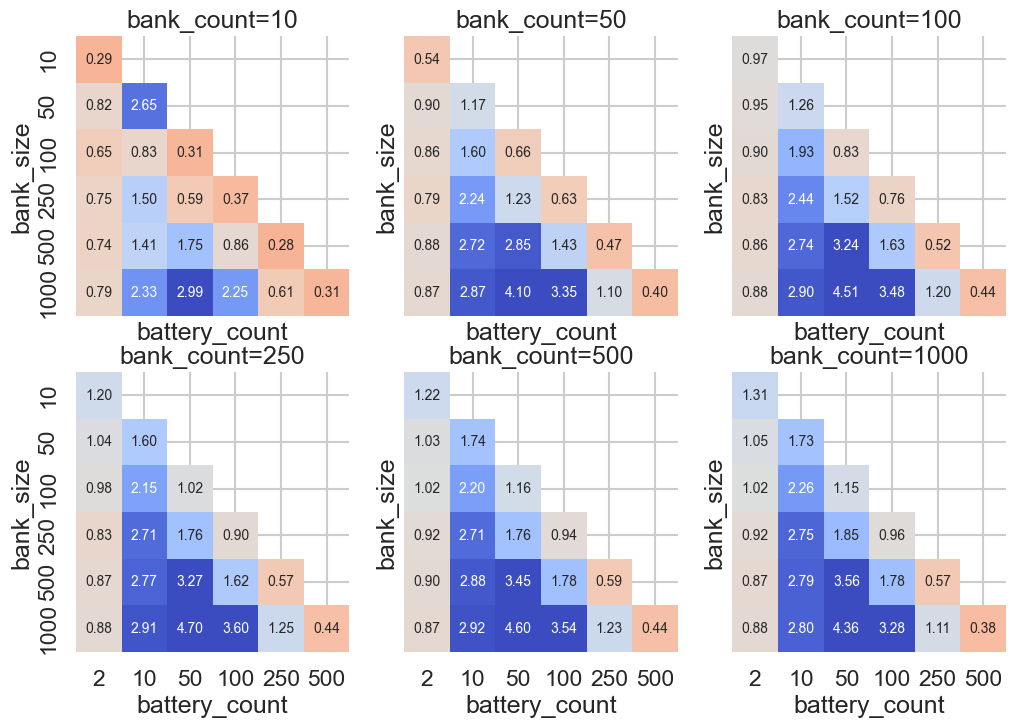

In [54]:
plot_speedup_heatmaps(results)

#### Sensitivity analysis
Next, we run a sensitivity analysis to see which parameters most affect the speedup of the vectorized approach over the iterative one. I varied one parameter at a time while keeping the others fixed at the default input values:
- Bank count: 200
- Bank size: 100
- Battery count: 12


##### Varying the amount of banks
As we can see here, the vectorized approach already outperforms the iterative one for more than 16 banks, but it caps out at a speedup of 2x above ~750 banks

benchmarks:   0%|          | 0/45 [00:00<?, ?it/s]

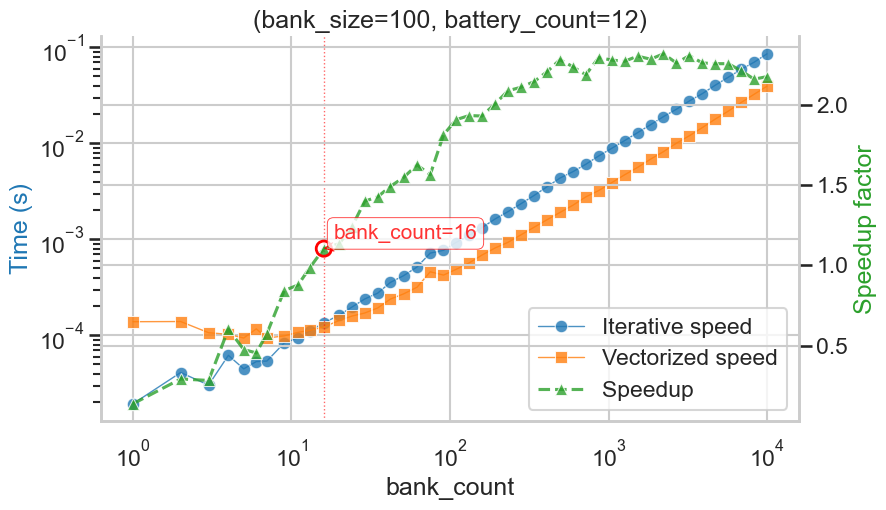

In [ ]:
varied_bank_count_results, plot = run_and_plot_benchmark(
    var=("bank_count", 1, 100),
    const_1=("bank_size", 100),
    const_2=("battery_count", 12),
    plot_op="return",
)


if plot is not None:
    fig, ax, ax2 = plot
    # Find first point where speedup > 1 and highlight it
    highlight_point = tuple(
        varied_bank_count_results[varied_bank_count_results["speedup"] > 1].iloc[0][["bank_count", "speedup"]]
    )
    plot_highlight_point(ax2, highlight_point, x_var="bank_count")

##### Varying the bank size
The vectorized approach outperforms the iterative from the start, and the speedup seems to grow logarithmically with bank size.

benchmarks:   0%|          | 0/50 [00:00<?, ?it/s]

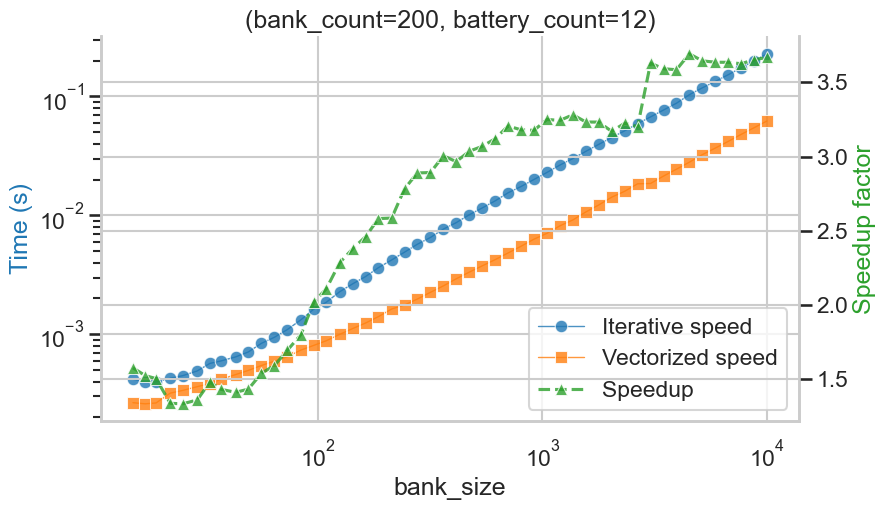

In [ ]:
varied_bank_size_results = run_and_plot_benchmark(
    var=("bank_size", 15, 10_000), const_1=("bank_count", 200), const_2=("battery_count", 12)
)

##### Varying the battery count
As expected, the iterative approach is faster for very low battery counts, since the cost of vectorization isn't worth it for small workloads.

The vectorized approach quickly overtakes the iterative one as battery count increases, peaking around 15 batteries.

However, after that, the speedup decreases again! This is likely because both approaches have to scan through most of the bank anyway, reducing the advantage of vectorization.

In [61]:
varied_battery_count_results = run_and_plot_benchmark(
    var=("battery_count", 1, 100), const_1=("bank_size", 100), const_2=("bank_count", 200), logx=False
)

benchmarks:   0%|          | 0/1 [00:00<?, ?it/s]

KeyError: 'bank_size'

I'm curious what this peak is caused by. I will run this benchmark for a range of battery sizes to see how the peak relates to bank size.

In [69]:
def find_battery_counts(min_bank_size: int = 25, max_bank_size: int = 25_000, step_count: int = 50) -> pd.DataFrame:
    """Find battery counts where speedup peaks and where goes below 1 again for each bank size in a log space."""
    rows = []
    for bank_size in tqdm(
        list(np.unique(np.logspace(np.log10(min_bank_size), np.log10(max_bank_size), step_count, dtype=int)))
    ):
        results_df, _ = run_and_plot_benchmark(
            var=("battery_count", 2, bank_size),
            const_1=("bank_size", bank_size),
            const_2=("bank_count", 10),  # lower bank count to reduce runtime
            plot_op="skip",
            show_progress=False,
            stop_after_speedup_below_1=True,
        )
        peak_speedup = results_df.loc[results_df["speedup"].idxmax(), "battery_count"]
        # Find the first battery_count where speedup is below 1 after the optimal point
        speedup_below_one = results_df.loc[
            (results_df["battery_count"] > peak_speedup) & (results_df["speedup"] < 1), "battery_count"
        ].min()
        rows.append({"bank_size": bank_size, "peak_speedup": peak_speedup, "below_one": speedup_below_one})

    return pd.DataFrame.from_records(rows, columns=["bank_size", "peak_speedup", "below_one"])


def plot_battery_counts(df: pd.DataFrame, *, log_axes: bool = True) -> None:
    """Plot peak speedups and inversion points vs bank sizes."""
    # Set color palette
    sns.set_theme(style="whitegrid")
    palette = sns.color_palette()

    # Prepare data
    x = df["bank_size"].to_numpy(dtype=float)
    y1 = df["peak_speedup"].to_numpy(dtype=float)
    y2 = df["below_one"].to_numpy(dtype=float)

    # Plot base data
    _, ax = plt.subplots(figsize=(8, 6))

    if log_axes:
        ax.set_yscale("log")
        ax.set_xscale("log")

    ax.plot(x, y1, color=palette[0], marker="o", label="Peak speedup", alpha=0.7)
    ax.plot(x, y2, color=palette[1], marker="^", label="Speedup goes below 1 again", alpha=0.7)

    # fit in log-log space
    logx, logy1, logy2 = np.log10(x), np.log10(y1), np.log10(y2)
    m1, b1 = np.polyfit(logx, logy1, 1)
    m2, b2 = np.polyfit(logx, logy2, 1)

    # Pearson r
    r1 = np.corrcoef(logx, logy1)[0, 1]
    r2 = np.corrcoef(logx, logy2)[0, 1]

    # fit curve on original scale
    fit_x = np.logspace(np.log10(x.min()), np.log10(x.max()), 200)
    fit_y1 = (10**b1) * fit_x**m1
    ax.plot(fit_x, fit_y1, color=palette[0], lw=1.5, label=f"y={10**b1:.2f}·x^{m1:.2f}")

    fit_y2 = (10**b2) * fit_x**m2
    ax.plot(fit_x, fit_y2, color=palette[1], lw=1.5, label=f"y={10**b2:.2f}·x^{m2:.2f}")

    ax.legend(loc="lower right")

    # metrics on plot and print
    ax.text(
        0.05,
        0.95,
        f"Pearson {r1=:.3f}, {r2=:.3f}",
        transform=ax.transAxes,
        va="top",
        bbox={"boxstyle": "round,pad=0.3", "fc": "white", "ec": "black", "alpha": 0.9},
    )
    plt.show()


In [ ]:
battery_counts_df = find_battery_counts()

  0%|          | 0/50 [00:00<?, ?it/s]

<Axes: xlabel='bank_size'>

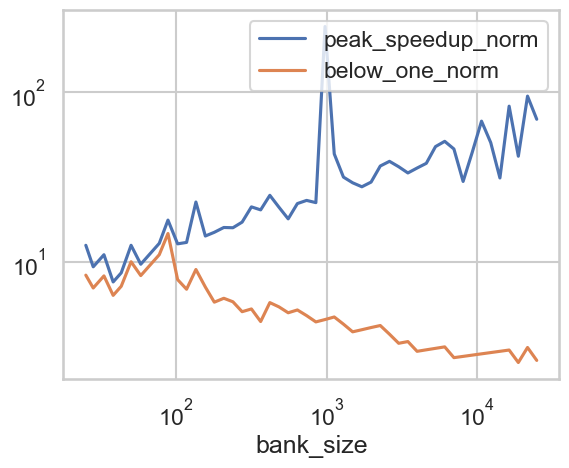

In [77]:
battery_counts_df["peak_speedup_norm"] = battery_counts_df["bank_size"] / battery_counts_df["peak_speedup"]
battery_counts_df["below_one_norm"] = battery_counts_df["bank_size"] / battery_counts_df["below_one"]
battery_counts_df.plot(x="bank_size", y=["peak_speedup_norm", "below_one_norm"], loglog=True)

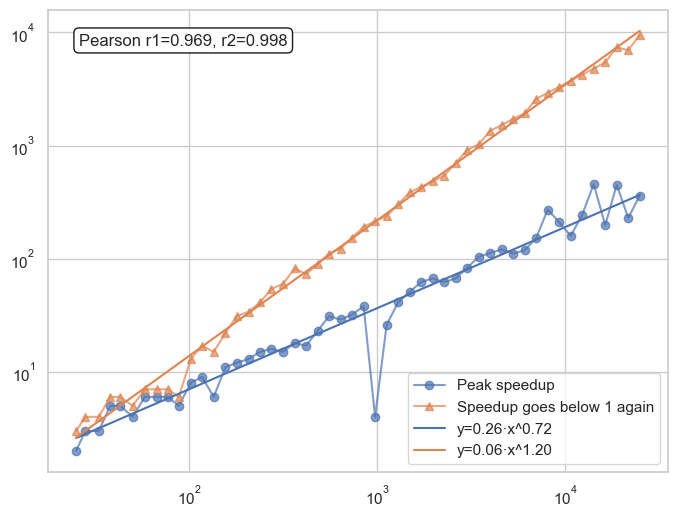

In [78]:
plot_battery_counts(battery_counts_df)